In [3]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import itertools

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load dataset
data = np.load('/content/ORL_faces.npz')

# Load the "Train Images"
x_data = data['trainX']
x_data = np.array(x_data, dtype='float32') / 255

y_data = data['trainY']

# Reshape images to include channel dimension
im_rows, im_cols = 112, 92
im_shape = (im_rows, im_cols, 1)
x_data = x_data.reshape(x_data.shape[0], *im_shape)

# Split the data into train, validation, and test sets using stratification
x_temp, x_test, y_temp, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=y_data, random_state=1234)
x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=0.1, stratify=y_temp, random_state=1234)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_valid shape:', x_valid.shape)
print('y_valid shape:', y_valid.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


x_train shape: (172, 112, 92, 1)
y_train shape: (172,)
x_valid shape: (20, 112, 92, 1)
y_valid shape: (20,)
x_test shape: (48, 112, 92, 1)
y_test shape: (48,)


In [5]:
def create_triplets(x, y):
    triplets = []
    n_classes = np.max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(n_classes)]

    for idx1 in range(len(x)):
        x_anchor = x[idx1]
        label_anchor = y[idx1]

        idx2 = np.random.choice(digit_indices[label_anchor])
        x_positive = x[idx2]

        label_negative = (label_anchor + np.random.randint(1, n_classes)) % n_classes
        idx3 = np.random.choice(digit_indices[label_negative])
        x_negative = x[idx3]

        triplets += [[x_anchor, x_positive, x_negative]]

    return np.array(triplets)

train_triplets = create_triplets(x_train, y_train)
valid_triplets = create_triplets(x_valid, y_valid)
test_triplets = create_triplets(x_test, y_test)

print('train_triplets shape:', train_triplets.shape)
print('valid_triplets shape:', valid_triplets.shape)
print('test_triplets shape:', test_triplets.shape)


train_triplets shape: (172, 3, 112, 92, 1)
valid_triplets shape: (20, 3, 112, 92, 1)
test_triplets shape: (48, 3, 112, 92, 1)


In [6]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras import backend as K
from keras.optimizers import Adam

def build_base_network(input_shape):
    model = Sequential([
        Conv2D(64, (10, 10), activation='relu', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(128, (7, 7), activation='relu'),
        MaxPooling2D(),
        Conv2D(128, (4, 4), activation='relu'),
        MaxPooling2D(),
        Conv2D(256, (4, 4), activation='relu'),
        Flatten(),
        Dense(4096, activation='sigmoid')
    ])
    return model

def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    pos_dist = K.sum(K.square(anchor - positive), axis=1)
    neg_dist = K.sum(K.square(anchor - negative), axis=1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0)
    return loss

input_shape = (im_rows, im_cols, 1)
base_network = build_base_network(input_shape)

input_anchor = Input(shape=input_shape, name='anchor')
input_positive = Input(shape=input_shape, name='positive')
input_negative = Input(shape=input_shape, name='negative')

processed_anchor = base_network(input_anchor)
processed_positive = base_network(input_positive)
processed_negative = base_network(input_negative)

merged_output = Lambda(lambda x: K.stack(x, axis=1))([processed_anchor, processed_positive, processed_negative])

model = Model([input_anchor, input_positive, input_negative], merged_output)
model.compile(loss=triplet_loss, optimizer=Adam(learning_rate=0.0001))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 112, 92, 1)]         0         []                            
                                                                                                  
 positive (InputLayer)       [(None, 112, 92, 1)]         0         []                            
                                                                                                  
 negative (InputLayer)       [(None, 112, 92, 1)]         0         []                            
                                                                                                  
 sequential (Sequential)     (None, 4096)                 2636473   ['anchor[0][0]',              
                                                          6          'positive[0][0]',        

In [7]:
history = model.fit(
    [train_triplets[:, 0], train_triplets[:, 1], train_triplets[:, 2]], np.zeros((train_triplets.shape[0], 3)),
    batch_size=128,
    epochs=50,  # You may adjust the number of epochs
    validation_data=([valid_triplets[:, 0], valid_triplets[:, 1], valid_triplets[:, 2]], np.zeros((valid_triplets.shape[0], 3)))
)


Epoch 1/50
2/2 [==============================] - 73s 18s/step - loss: 0.1953 - val_loss: 0.1743
Epoch 2/50
2/2 [==============================] - 69s 21s/step - loss: 0.1821 - val_loss: 0.1209
Epoch 3/50
2/2 [==============================] - 63s 18s/step - loss: 0.1406 - val_loss: 0.0422
Epoch 4/50
2/2 [==============================] - 66s 18s/step - loss: 0.0684 - val_loss: 0.0054
Epoch 5/50
2/2 [==============================] - 74s 18s/step - loss: 0.0476 - val_loss: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 65s 18s/step - loss: 0.0534 - val_loss: 0.0000e+00
Epoch 7/50
2/2 [==============================] - 63s 18s/step - loss: 0.0528 - val_loss: 0.0000e+00
Epoch 8/50
2/2 [==============================] - 67s 18s/step - loss: 0.0421 - val_loss: 0.0000e+00
Epoch 9/50
2/2 [==============================] - 64s 18s/step - loss: 0.0265 - val_loss: 0.0000e+00
Epoch 10/50
2/2 [==============================] - 73s 19s/step - loss: 0.0178 - val_loss: 0.0000e+00
Epoch

2/2 [==============================] - 9s 2s/step - loss: 0.0108
Test loss: 0.010767731815576553


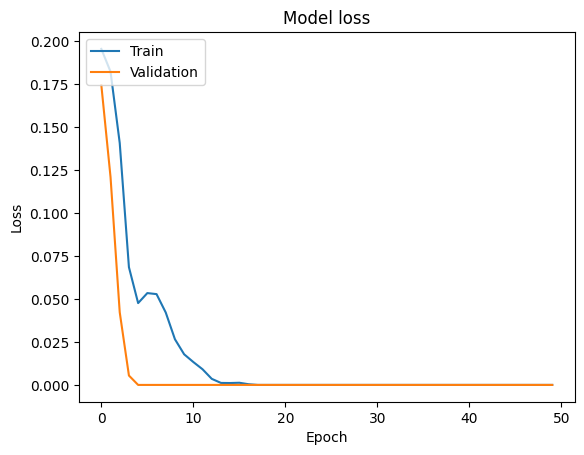

In [12]:
test_loss = model.evaluate([test_triplets[:, 0], test_triplets[:, 1], test_triplets[:, 2]], np.zeros((test_triplets.shape[0], 3)))
print('Test loss:', test_loss)

# Plot training history
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


2/2 [==============================] - 10s 4s/step
Accuracy: 0.0625


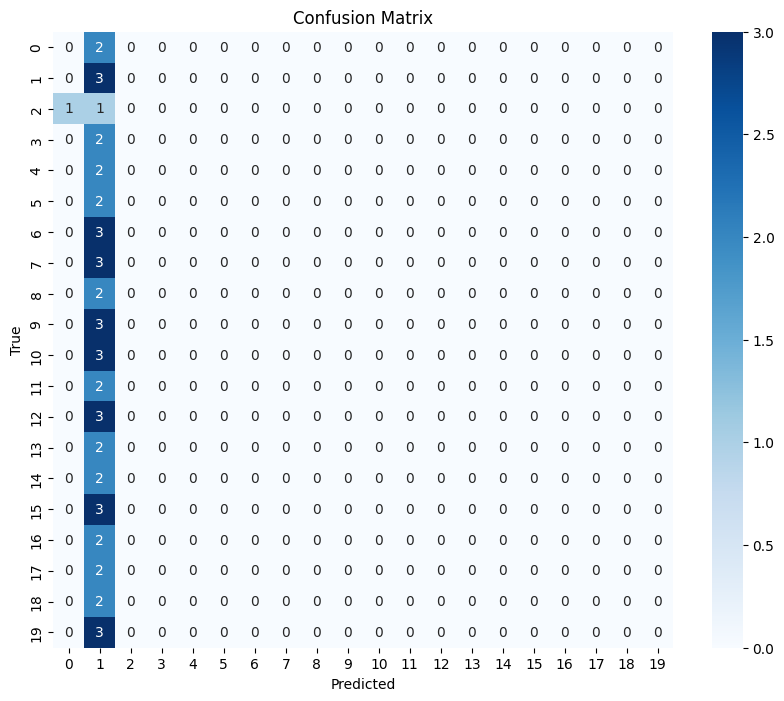

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.06      1.00      0.12         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         2
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [21]:
import seaborn as sns
import numpy as np
def predict_triplet_classes(triplets, model):
    anchor_embeddings = model.predict([triplets[:, 0], triplets[:, 1], triplets[:, 2]])
    anchor_embeddings = np.squeeze(anchor_embeddings)  # Squeeze to remove extra dimensions

    pos_dist = np.linalg.norm(anchor_embeddings[:, 0, :] - anchor_embeddings[:, 1, :], axis=1)
    neg_dist = np.linalg.norm(anchor_embeddings[:, 0, :] - anchor_embeddings[:, 2, :], axis=1)

    return (pos_dist < neg_dist).astype(int)

# Predict classes for the test set
predicted_classes = predict_triplet_classes(test_triplets, model)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy: {accuracy}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_report = classification_report(y_test, predicted_classes, target_names=np.unique(y_test).astype(str))
print(class_report)

# Extract precision, recall, f1-score for each class
report_dict = classification_report(y_test, predicted_classes, target_names=np.unique(y_test), output_dict=True)
precision = report_dict['weighted avg']['precision']
recall = report_dict['weighted avg']['recall']
f1_score = report_dict['weighted avg']['f1-score']

print(f'Weighted Precision: {precision}')
print(f'Weighted Recall: {recall}')
print(f'Weighted F1-Score: {f1_score}')